## Discontinuous Galerkin for the advection equation

### Motivation
The motivation for this study stems from the observation that our 3d turbulence simulations in Feltor seem to 
 - require a significant higher resolution  and 
 - seem to generate significantly smaller scales
 
than finite Difference simulations of the same region like Grillix or Tokam3X. 
Since our simulations operate at the limit of our available HPC resources simply increasing the resolution further is not an option. This results in the situation where Feltor cannot simulate the same regions of the tokamak that other frameworks seem to be able to.

Currently, there are two hypotheses
 - the gyro-fluid model in use physically produces smaller scales than the drift-fluid models
 - the required high resolution is a fundamental problem of the discontinuous Galerkin discretization
 
In this report we want to test the second hypothesis in more detail. In order to do this we consider a simple test scenario as a testbed for a variety of dG and FD discretization and filter techniques. 
 
### A simple test scenario

We consider the 2d incompressible Euler equations
\begin{align}
    \frac{\partial \omega}{\partial t} + \nabla\cdot({\vec v \omega}) = 0 \nonumber\\
\omega = - \Delta\phi \quad v_x = - \phi_y \quad v_y = \phi_x
\end{align}

with vorticity $\omega$ and stream-function $\phi$. The Euler equations have an infinite amount of conserved quantities
among them the total vorticity $V$, the kinetic energy $E$ and the enstrophy $\Omega$
 \begin{align}
     V := \int_D \omega \mathrm{d}A\quad
     E :=\frac{1}{2} \int_D \left( \nabla \phi\right)^2 \mathrm{d}A \quad
     \Omega_n:= \frac{1}{2} \int_D \omega^{2n }\mathrm{d}A
 \end{align}
Often, these invariants are taken as a measure of quality of the integrator.


In [3]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import simplesimdb as simplesim # this one is our own database manager
import itertools
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [4]:
m = simplesim.Manager(directory='advection', executable='./execute.sh', filetype='nc')
content = m.table()

In [5]:
# Construct the Gaussian weights on our grids
def gauss_weights( js) :
    n = js["n"]
    Nx = js["Nx"]
    Ny = js["Ny"]
    lx = js["x"][1]-js["x"][0]
    ly = js["y"][1]-js["y"][0]
    hx = lx/Nx
    hy = ly/Ny
    (x,w) = np.polynomial.legendre.leggauss(js["n"])
    weights1dX = np.tile( w, js["Nx"])
    weights1dY = np.tile( w, js["Ny"])
    return np.reshape( np.kron( weights1dY, weights1dX)*hy/2.0*hx/2.0 , (js["n"]*js["Ny"], js["n"]*js["Nx"]))

In [6]:
# Let's creat a nice lookup table in pandas and also add some diagnostics
last_out = list()
for f in content :
    ncin = Dataset( m.select(f), 'r', format="NETCDF4")
    # time, xc, yc, vorticity, potential,
    # error(t), time_per_step(t), energy_1d(t), enstrophy_1d(t), vorticity_1d(t)
    max_idx = ncin.variables["time"].shape[0]-1
    vo = ncin["vorticity"][:,:,:]
    weights = gauss_weights( f["grid"])
    tps = ncin["time_per_step"][:]
    ene = ncin["energy_1d"][:]
    ens = ncin["enstrophy_1d"][:]
    vor = ncin["vorticity_1d"][:]
    vor20 = 1./2.*np.sum( vo[0,:,:]**2*weights )
    vor21 = 1./2.*np.sum( vo[max_idx,:,:]**2*weights )
    vor40 = 1./4.*np.sum( vo[0,:,:]**4*weights )
    vor41 = 1./4.*np.sum( vo[max_idx,:,:]**4*weights )
    vor60 = 1./6.*np.sum( vo[0,:,:]**6*weights )
    vor61 = 1./6.*np.sum( vo[max_idx,:,:]**6*weights )
    e = dict()
    e["id"] = m.hashinput(f)
    e["error"] = {"solution" : float(ncin["error"][max_idx])}
    e["error"]["vorticity2"] = abs( vor20-vor21)/vor20 # same as enstrophy
    e["error"]["vorticity4"] = abs( vor40-vor41)/vor40 
    e["error"]["vorticity6"] = abs( vor60-vor61)/vor60 
    e["error"]["enstrophy"] = abs(ens[max_idx]-ens[0])/ens[0]
    e["error"]["energy"] = abs(ene[max_idx]-ene[0])/ene[0]
    e["error"]["vorticity"] = abs(vor[max_idx]-vor[0])
    
    e["time_to_solution"] = np.sum(tps)*float(f["output"]["itstp"])
    last_out.append(e)

In [7]:
df = pd.json_normalize( last_out)
df.set_index( "id", inplace=True)
df

,time_to_solution,error.solution,error.vorticity2,error.vorticity4,error.vorticity6,error.enstrophy,error.energy,error.vorticity
id,,,,,,,,
c36cf6b759d7e0ef96ecdc264d95647116fa5efc,4.86e+01,0.00e+00,2.20e-01,3.79e-01,4.01e-01,2.20e-01,7.42e-04,1.67e-09
bb7d5c679271d712914386da9f33f0bd34282715,1.69e+02,0.00e+00,1.19e-01,2.64e-01,2.61e-01,1.19e-01,6.05e-04,3.29e-09
dad0aa7d680db7abd33424d63e967a76dfe76f13,1.10e+00,1.36e-02,4.51e-03,1.55e-02,2.71e-02,4.51e-03,5.37e-03,2.14e-10
93573d0a0852e6236d1e24dc67483d8281557480,7.68e+00,0.00e+00,1.85e-01,2.60e-01,1.25e-01,1.85e-01,9.22e-04,4.79e-15
e3122c1b8e4191b331ca01d3982c13f594f80888,1.41e+01,2.10e-03,8.13e-06,7.19e-05,1.73e-04,8.13e-06,3.86e-06,5.22e-16
...,...,...,...,...,...,...,...,...
94097f23e0ffcaee09011134b3bd9aebf0dab97c,1.16e+01,9.61e-02,3.47e-02,7.45e-02,1.08e-01,3.47e-02,2.58e-02,1.04e-04
45e392d3a1079ca5e4747ef77a30cef026b7a6b1,7.61e+01,9.60e-02,3.47e-02,7.45e-02,1.08e-01,3.47e-02,2.58e-02,5.02e-16
b4e5eba97e0f87e02c40314a90146937874128db,4.18e+01,1.16e-03,1.65e-06,1.18e-05,1.27e-05,1.65e-06,7.82e-07,1.59e-12


In [8]:
def plot (f, save) :
    ncin = Dataset( m.select(f), 'r', format="NETCDF4")
    # time, xc, yc, vorticity, potential,
    # error(t), time_per_step(t), energy_1d(t), enstrophy_1d(t), vorticity_1d(t)
    max_idx = ncin.variables["time"].shape[0]-1
    xc = ncin["xc"][:,:]
    yc = ncin["yc"][:,:]
    vo = ncin["vorticity"][max_idx,:,:]
    po = ncin["potential"][max_idx,:,:]
    time = ncin["time"][:]
    max_idx = np.size( time)-1
    fig,ax=plt.subplots(1,2,figsize=(2*4,4),dpi= 80, facecolor='w', edgecolor='k')

    ax[0].pcolormesh(xc,yc,vo, vmin=-7, vmax=7, shading='gouraud', cmap='seismic' )
    ax[0].set_title( f["grid"]["n"])
    ax[0].axis('scaled')
    viscous = f["regularization"]["type"] == "viscosity"
    modal  = f["regularization"]["type"] == "modal"
    mms = f["init"]["type"] == "mms"
    hashed = m.hashinput(f)
    textstr = '\n'.join((
    r'$%.d \times %.d \times %d $' % (f["grid"]["n"], f["grid"]["Nx"],
                                      f["output"]["itstp"]*f["output"]["maxout"] ),
    #r'$n=%.d\ N=%.d$' % (f["grid"]["n"], f["grid"]["Nx"] ),
    r'$\varepsilon=%.2e$' % (df.loc[hashed,"error.solution"] ) if mms else '',
    r'$\varepsilon_E=%.2e$' % (df.loc[hashed,"error.energy"] ),
    r'$\varepsilon_V=%.2e$' % (df.loc[hashed,"error.vorticity"] ),
    r'$\varepsilon_{V2}=%.2e$' % (df.loc[hashed,"error.vorticity2"] ),
    r'$\varepsilon_{V4}=%.2e$' % (df.loc[hashed,"error.vorticity4"] ),
    r'$\varepsilon_{V6}=%.2e$' % (df.loc[hashed,"error.vorticity6"] ),   
    r'$T_\mathrm{sim}=%.2f$' % (df.loc[hashed,"time_to_solution"] ),
        '',
    'multiplication: ' + f["advection"]["multiplication"] ,
    'advection      : ' + f["advection"]["type"] ,
    'regularization: ' + f["regularization"]["type"] + (
        "("+str(f["regularization"]["order"])+")"  if viscous else 
        r"$\ (\eta_c=%.1f$"%f["regularization"]["eta_c"]+")" if modal else ""
    ), 
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    #ax[1].set_title( f["grid"]["n"])
    ax[1].axis('off')
    if save :
        plt.savefig( "advection/"+hashed+".png",bbox_inches='tight')
        plt.close()
    else :
        pass

In [9]:
# PLOT ALL INTO FILE
#for f in content:
#    plot(f,True)

### Initial condition 
We consider the double shear layer problem

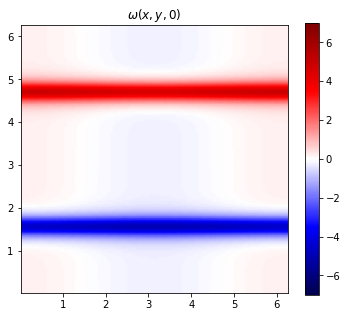

In [14]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "pointwise", "type" : "arakawa"}
        and entry["regularization"]["type"] == "none"
        and ( entry["grid"]["n"] == 3)
       ),
    content))
f = found[0]
ncin = Dataset( m.select(f), 'r', format="NETCDF4")
xc = ncin["xc"][:,:]
yc = ncin["yc"][:,:]
vo = ncin["vorticity"][0,:,:]
time = ncin["time"][:]
plt.figure(figsize=(6, 5))
plt.pcolormesh(xc,yc,vo, vmin=-7, vmax=7, shading='gouraud', cmap = 'seismic' )
plt.colorbar()
plt.axis('scaled')
plt.title(r'$\omega(x,y,0)$')
plt.show()

We will then integrate the solution from $t=0$ to $t=10$ using various methods.
### A naive approach

The first approach to discretize is to simply use centered differences (or the dG analogue) for the flux 
\begin{align} 
\frac{\partial}{\partial x} f \rightarrow \frac{f_{i+1}-f_{i-1}}{2h_x}
\end{align}

It is well known that the forward in time, centered in space method for solving
hyperbolic systems is **unconditionally unstable** {cite}`LeVeque`.
Reference {cite}`Liu2000` reports that the centered flux does not have any numerical
diffusion while the upwind flux does.
They also prove that upwind and centered fluxes do not dissipate energy.
```{bibliography} references.bib
```


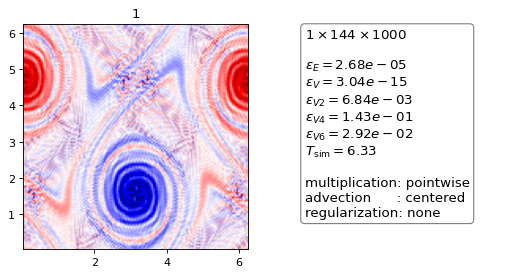

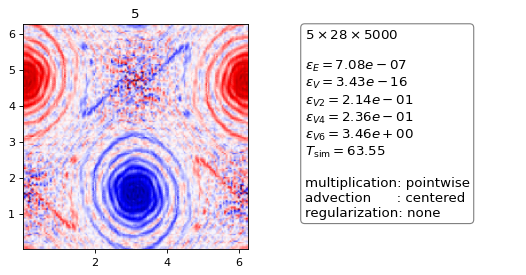

In [16]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "pointwise", "type" : "centered"}
        and entry["regularization"]["type"] == "none" # and entry["regularization"]["order"] == 2):
        and (entry["grid"]["n"] == 1 or entry["grid"]["n"] == 5)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

We observe that
-  both the FD and the dG scheme of order 5 produce a lot of oscillations
- even though the number of spatial points is the same (~140) the dG scheme has to use a 5 times smaller time step

### Arakawa
The Arakawa scheme was generalized for dG methods in {cite}`Einkemmer2014` and is a method that conserves vorticity, energy and enstrophy exactly. Just as for the centered differences it is well-known that the scheme produces oscillations without a diffusive term.

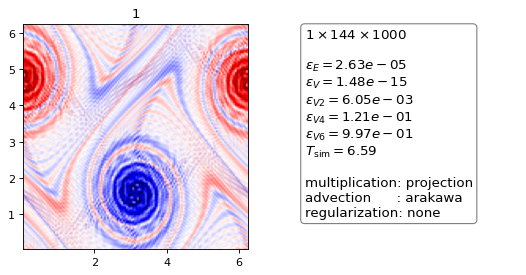

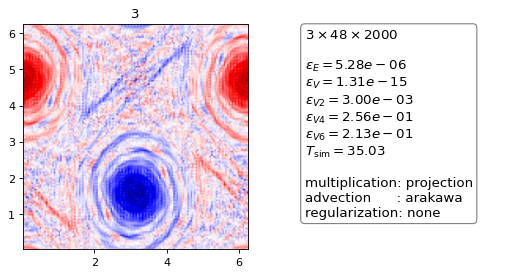

In [17]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "pointwise", "type" : "arakawa"}
        and entry["regularization"]["type"] == "none"
        and (entry["grid"]["n"] == 1 or entry["grid"]["n"] == 3)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

- The Arakawa scheme without regularization is indeed always unstable (also for projection method described later)
- Note that the higher order simulation takes 5-6 times longer to complete

### Upwind scheme
The idea of an upwind scheme is to use either a forward or a backward discretization of the flux $f=\omega v$ depending on the sign of the velocity
\begin{align}
\frac{\partial}{\partial x} f \rightarrow \begin{cases}
    \frac{f_{i+1}-f_i}{h} \text{ if } v < 0 \\
    \frac{f_{i} - f_{i-1}}{h} \text{  if } v > 0
    \end{cases}
\end{align}

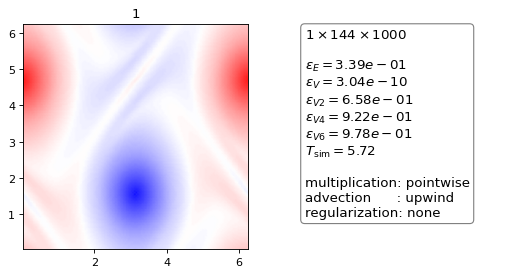

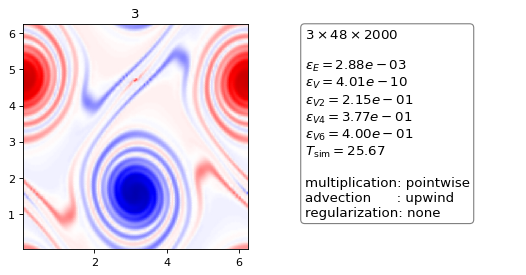

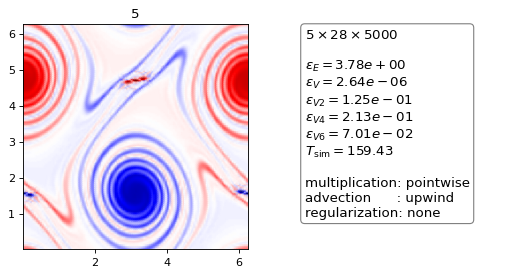

In [10]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "pointwise", "type" : "upwind"}
        and entry["regularization"]["type"] == "none" # and entry["regularization"]["order"] == 2):
        and (entry["grid"]["n"] == 1 or entry["grid"]["n"] == 3 or entry["grid"]["n"] == 5)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

- The upwind scheme of first order introduces a lot of numerical diffusion,
- the higher order dG schemes with pointwise multiplication seem to be unstable at symmetry points

### Correct multiplication of dG polynomials
In the computation of the flux $n v$ the approach that we used above (termed **pointwise**) was to simply compute the pointwise multiplication of the nodal discretization {cite}`NodalDG`. However, the correct approach when multiplying
two dG discretized functions is to interpolate both onto a  higher degree polynomial (of degree $2n$) and then projecting the result back unto the lower degree polynomial $n$). We call this the **projection** method {cite}`NodalDG`.
```{bibliography} references.bib
```

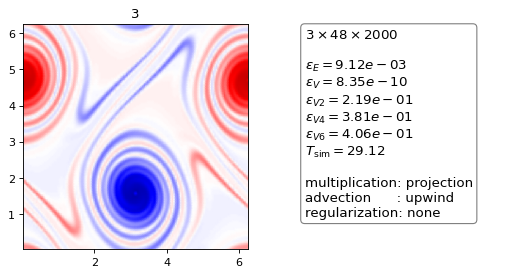

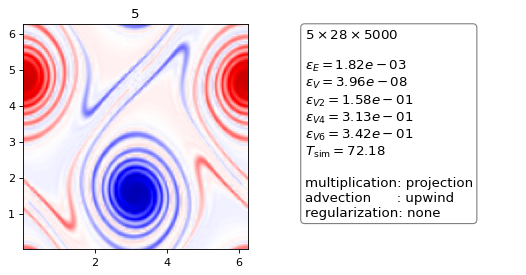

In [11]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "projection", "type" : "upwind"}
        and entry["regularization"]["type"] == "none" # and entry["regularization"]["order"] == 2):
        and (entry["grid"]["n"] == 3 or entry["grid"]["n"] == 5)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

- Only the upwind scheme with correct multiplication and projection of polynomials seems to work reliably without regularization. Only small oscillations are visible.

### Modal filtering

In {cite}`NodalDG` an alternative to the projection method was suggested to stabilize dG methods. The modal filter can be thought of as a de-aliasing technique for dG methods and is thought to be an alternative to artificial diffusion techniques.
The technique consists in applying the filter $f(\eta)$ to each mode $\eta$ after every timestep
\begin{align}
\omega_\eta^{n+1} = f(\eta) \omega_\eta^n
\end{align}
We experiment with the exponential filter shown in the next graph

![Filter function](filter.png)
```{bibliography} references.bib
```

First, let us try to apply the filter to the upwind scheme with pointwise multiplication (as was originally suggested)

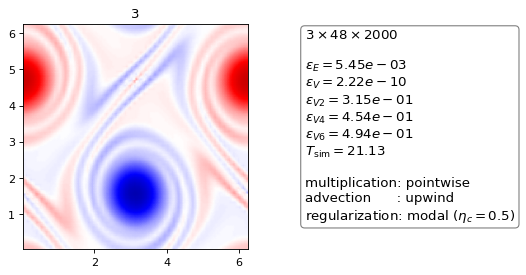

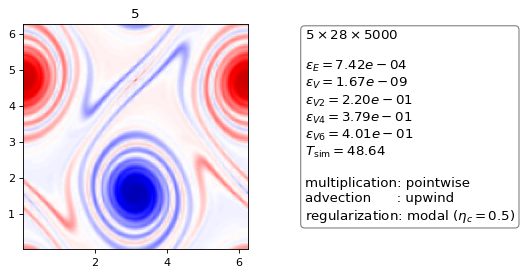

In [24]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and entry["advection"] == {"multiplication": "pointwise", "type" : "upwind"}
        and ( (entry["regularization"]["type"] == "modal" and entry["regularization"]["eta_c"] == 0.0)
             or (entry["regularization"]["type"] == "modal" and entry["regularization"]["eta_c"] == 0.5)
            )
        and (entry["grid"]["n"] == 3 or entry["grid"]["n"] == 5)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

- The modal Filter introduces numerical diffusion but seems to have troubles at the symmetry points
- also true for $\eta_c = 0$ filter and the projection method
- in a way the modal filter is a projection filter (projecting out high frequencies) and should thus be equivalent to a projection method of lower order and the same number of cells

Let us now try to apply the modal filter on the Arakawa scheme

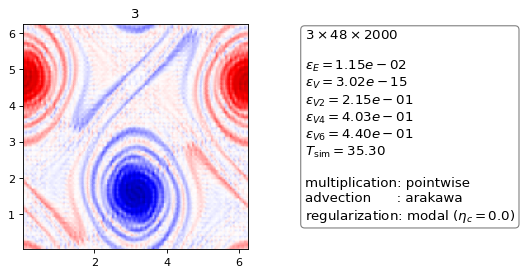

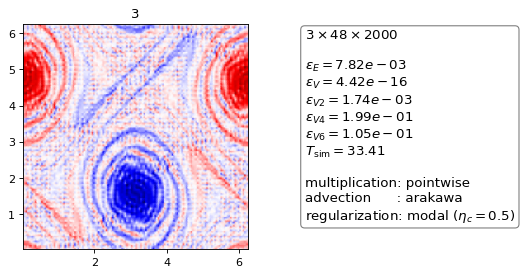

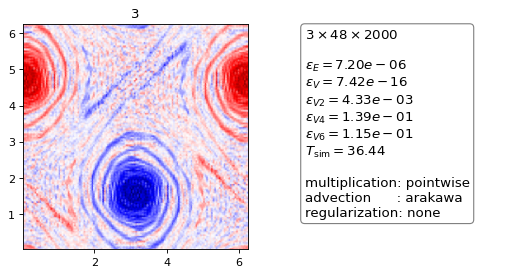

In [19]:
found = list(filter( lambda entry : (
            entry["init"]["type"] == "shear"
        and (entry["advection"] == {"multiplication": "pointwise", "type" : "arakawa"})
            #or entry["advection"] == {"multiplication": "projection", "type" : "centered"})
        and ( (entry["regularization"]["type"] == "modal" and entry["regularization"]["eta_c"] == 0.0)
             or (entry["regularization"]["type"] == "modal" and entry["regularization"]["eta_c"] == 0.5)
             or entry["regularization"]["type"] == "none")
        and (entry["grid"]["n"] == 3)
       ),
    content))
found.sort( key = lambda f : f["grid"]["n"]) # SORT ACCORDING TO N
for f in found:
    plot(f, False)

- The modal filter with $\eta_c=0.5$, $s=8$ and $\alpha=36$ improves the oscillations in the Arakawa scheme but does not entirely remove them
- The modal filter with $\eta_c=0.0$, $s=8$ and $\alpha=36$ further dampens the oscillations but overdampens the vortex structure while still having trouble at the symmetry points
- This situation is the same for the projection and the centered methods

**The modal filter is unable to make the unstable techniques stable and is somewhat similar to a projection method of lower order** -> maybe look more into equivalence of projection and modal filtering? Especially for order 3 this seems evident

### Viscosity and hyperviscosity

In order to make the centered and Arakawa discretization stable, usually artificial viscosity is added to the equations to discretize
\begin{align}
 \frac{\partial}{\partial t} + \nabla \cdot ( \omega \vec v) = - (-\nu \Delta)^s \omega
 \end{align}
 where $s=1,2,...$ is the order. This technique clearly destroys the exact energy
 and enstrophy conservation of the original system.
 Since Fourier modes are Eigenfunctions of the Laplace operator the artificial viscosity can be seen as a low pass filters of order $s$ for spectral schemes. In contrast to a modal dG filter however, the spectral filter applies to the entire box as a whole and not just to individual cells.
 We now want to show that
  - the schemes that produce less oscillations also need less viscosity
  - in particular the order 1 arakawa scheme needs less viscosity than higher order dG schemes (because higher order polynomials produce more oscillations)
  
We will now use the semi-implicit Karniadakis scheme.
  